In [1]:
!pip install gensim==4.2.0
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 6.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [623 lines of output]
      /Users/benware/anaconda3/lib/python3.11/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpyt

In [4]:
import gensim
import csv
import requests
import xml.etree.ElementTree as ET
import pprint
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import re
import xml.etree.ElementTree as ET
from itertools import islice
from gensim.test.utils import get_tmpfile
import pandas as pd
import html

pp = pprint.PrettyPrinter(indent=2)
USER_AGENT = "10K risks nlp test" #required for sec requests so we don't look like an automated script

In [5]:
#LOADS MODEL only requires imports from above
model = Doc2Vec.load("model")

FileNotFoundError: [Errno 2] No such file or directory: 'model'

In [9]:
#returns the index of the nth substring within str
#example str ="I'm Ben Ware, my name is Ben Ware" sub = "Ben" n = 2 -> 27
def findSubstringIndex(string,sub,n):
    start = string.find(sub)
    while start >= 0 and n > 1:
        start = string.find(sub, start+len(sub))
        n -= 1
    return start

In [7]:
# @url is where the 10k is hosted will return a string which is the risk factor section of that 10k
def get10kText(url):
    # creating HTTP response object from given url
    resp = requests.get(url,headers={"User-Agent":USER_AGENT})
    ten_k_txt = html.unescape(resp.content.decode("utf-8"))
    ten_k_txt = ten_k_txt.replace(u'\xa0', u' ')
    #first replaces anything between <angle brackets> with a space, then replaces all whitespace chunks with exactly one space, and splits on them
    #should give just words hopefully

    #Kind of convuluted the strings "Item 1A." and "Item 1B." appear twice once in the index once where we want them, by first splitting to Item 1B. we chop of the index copies

    ten_k_txt = ten_k_txt[findSubstringIndex(ten_k_txt,"Item 1A.",2):findSubstringIndex(ten_k_txt,"Item 1B.",2)]
    #regex and split to remove all html tags/styles and split the document by word creating a corpus(list of words)
    return re.sub('[\n\t\r ]+', ' ',re.sub(r'<[^>]+>',' ',ten_k_txt)).split(' ')

In [22]:
#text file relating ticker to cik
def getTickers():
  cik_url = 'https://www.sec.gov/include/ticker.txt'
  resp = requests.get(cik_url,headers={"User-Agent":USER_AGENT})
  ticker_cik_pairs = resp.content.decode("utf-8").split("\n")

  return {pair.split("\t")[0]:pair.split("\t")[1].zfill(10) for pair in ticker_cik_pairs}



In [13]:
#TODO add error catching, and check if the xml is always the same right now it relies on child order, and url being /cik/accession-number-no-hyphens/accession-number.txt
def findMostRecent10kUrl(cik):
  try:
    ten_k_feed_url = 'https://data.sec.gov/rss?cik={}&type=10-K&count=1'.format(cik)
    resp = requests.get(ten_k_feed_url,headers={"User-Agent":USER_AGENT})
    tree = ET.fromstring(resp.content.decode("utf-8"))
    #last child of feed is the entry, its first child is content-title, its first child is accession number
    accession_number = tree[len(tree) -1][1][1].text

    return 'https://www.sec.gov/Archives/edgar/data/{}/{}/{}.txt'.format(cik,accession_number.replace("-",""),accession_number)
  except:
    #Either, there were no 10k's in the rss feed, or the feed was formatted differently
    return False



In [15]:
#get tickers of s&p 500 companies
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

#the first table on the wiki page has a symbol column
tickers = payload[0]['Symbol'].values.tolist()
tickers = [ticker.replace(".","-").lower() for ticker in tickers]

In [28]:
#dictionary of ticker-cik
ciks = getTickers();

In [25]:
#Maps ticker to most recent 10kURL involves len(tickers) calls to the SEC
ten_k_url_dict = {}
for ticker in tickers:
    if ticker in ciks:
        ten_k_url_dict[ticker] = findMostRecent10kUrl(ciks[ticker])
    else:
        print(f"No 10k found for {ticker}")

In [ ]:
# Maps ticker to the risk factor section of the 10k these sections are quite large
ten_k_dict = {}
for ticker,url in ten_k_url_dict.items():
  try:
    if url:
      ten_k_dict[ticker]=get10kText(url)
    else:
      print("Failed to find 10k url for {}".format(ticker))
  except:
    print("Couldn't find a cik for {}".format(ticker))


In [ ]:
#CREATES NEW MODEL
documents = [TaggedDocument(ten_k_dict[key], [key]) for key in ten_k_dict] #expects a list of words
#fiddle with numbers here, lookup other models maybe, find most accurate one
model = Doc2Vec(documents,vector_size=100, workers=4,epochs=20,alpha=0.025)
model.train(documents,total_examples=model.corpus_count,epochs=model.epochs)

# model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

In [ ]:
#SAVES CURRENT MODEL
model.save("model")

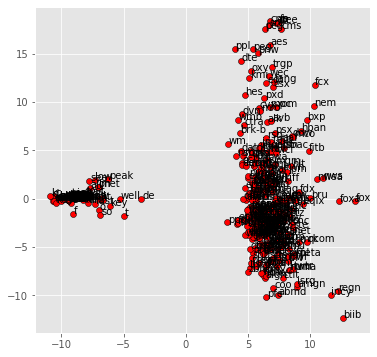

In [ ]:
#Puts model into 2D space using Principle Component Analysis(PCA) to figure out which compoenents are most relevant
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#model.dv.index_to_key, has the names of all documents ie ['mmm','f','msft',....]
tickers = model.dv.index_to_key
doc_vectors = np.array([model[ticker] for ticker in tickers])

#Projects model into 2 dimensions
twodim = PCA().fit_transform(doc_vectors)[:,:2]

plt.figure(figsize=(6,6))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for ticker, (x,y) in zip(tickers, twodim):
    plt.text(x+0.05, y+0.05, ticker)


In [ ]:
#GENERATES JSON with nodes and links connecting  S&P 500 companies to there most similiar 3, that is 500 nodes ~1500 links
links = []
nodes = []
for ticker in tickers:
  try:
    similarity_vector = model.dv.most_similar(topn=2,positive=[ticker])
    node = {'id':ticker} #more information could be added about a company in this dictionary
    nodes.append(node);
    for sim_company in similarity_vector: #sim_company is (ticker(str),value(float, 0-1))
      #Only add this link if it's a duplicate ie the target ticker hasn't been checked
        link = {};
        link['source'] = ticker
        link['target'] = sim_company[0]
        link['value'] = sim_company[1]
        links.append(link)
    #links will have two copies of every relation as the graph is undirected
  except:
    print("ticker {} wasn't in the model".format(ticker))

data = {'nodes':nodes, 'links':links}


import json
#writes Nodes and links json to my google drive
with open("/content/drive/My Drive/ten_k_nlp/S&Pdata.json", "w") as outfile:
    json.dump(data, outfile)



ticker frc wasn't in the model
ticker sbny wasn't in the model


In [ ]:
print(model.dv.most_similar(topn=3,positive=['ups']))

[('fdx', 0.8711217045783997), ('dal', 0.7747839093208313), ('syy', 0.7719271183013916)]


In [ ]:
# Writes company icons into folders, currently pointing to my google drive
import urllib.request

for ticker in tickers:
  try:
    urllib.request.urlretrieve(f"https://eodhistoricaldata.com/img/logos/US/{ticker}.png", f"/content/drive/My Drive/ten_k_nlp/ticker_icons/{ticker}.png")
  except:
    try:
      urllib.request.urlretrieve(f"https://eodhistoricaldata.com/img/logos/US/{ticker.upper()}.png", f"/content/drive/My Drive/ten_k_nlp/ticker_icons/{ticker}.png")
    except:
      print("Couldn't find image for {}".format(ticker))


 #Some are upper some are lower probably try both and get whichever you can

In [ ]:
#create a tree starting from one ticker, grab its top 3 and repeat however many times
seenTickers = []
nodes = []
links = []
def getNSimilar(ticker,n):
  similarity_vector = model.dv.most_similar(topn=n,positive=[ticker])
  nodes.append({'id':ticker})
  seenTickers.append(ticker)
  for sim_company in similarity_vector: #sim_company is (ticker(str),value(float, 0-1))
      #Only add this link if it's a duplicate ie the target ticker hasn't been checked
        link = {};
        link['source'] = ticker
        link['target'] = sim_company[0]
        link['value'] = sim_company[1]
        links.append(link)
        if(sim_company[0] not in seenTickers):
          getNSimilar(sim_company[0],n)


#UPDATE THESE TO GET DIFFERENT TREES
startingTicker = 'ba'
n = 3

data = {'nodes':nodes, 'links':links}
getNSimilar(startingTicker,n)
import json
#writes Nodes and links json to my google drive
with open(f"/content/drive/My Drive/ten_k_nlp/{startingTicker}{n}Tree.json", "w") as outfile:
    json.dump(data, outfile)

In [ ]:
print(model.dv.most_similar(topn=3,positive=['luv']))

[('ual', 0.8015658259391785), ('lh', 0.7550608515739441), ('iex', 0.7544623613357544)]
